### **Import TensorFlow and other libraries**

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

### **Load the dataset**

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4422102/4422102 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


### **Basic autoencoder**
Define an autoencoder with two Dense layers: an encoder, which compresses the images into a 64 dimensional latent vector, and a decoder, that reconstructs the original image from the latent space.

To define your model, use the [Keras Model Subclassing API](https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing).

In [3]:
class Autoencoder(Model):
  def __init__(self, latent_dim, shape):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim
    self.shape = shape
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(tf.math.reduce_prod(shape).numpy(), activation='sigmoid'),
      layers.Reshape(shape)
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded


shape = x_test.shape[1:]
latent_dim = 64
autoencoder = Autoencoder(latent_dim, shape)

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [6]:
autoencoder.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 64)                50240     
                                                                 
 sequential_1 (Sequential)   (None, 28, 28)            50960     
                                                                 
Total params: 101200 (395.31 KB)
Trainable params: 101200 (395.31 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.0236 - val_loss: 0.0132
Epoch 2/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0116 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 13s 7ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0095 - val_loss: 0.0093
Epoch 5/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.0091 - val_loss: 0.0091
Epoch 7/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 8/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.0089 - val_loss: 0.0090
Epoch 9/10
1875/1875 [==============================] - 7s 4ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 10/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.00

In [21]:
autoencoder.layers[0].get_weights()[0].shape

(784, 64)

In [29]:
input = tf.keras.layers.Input(shape=(None, 784))
hidden = tf.keras.layers.Dense(64, activation='relu', weights=autoencoder.layers[0].get_weights(), trainable=False)(input)
output = tf.keras.layers.Dense(10, activation='softmax')(hidden)

In [42]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

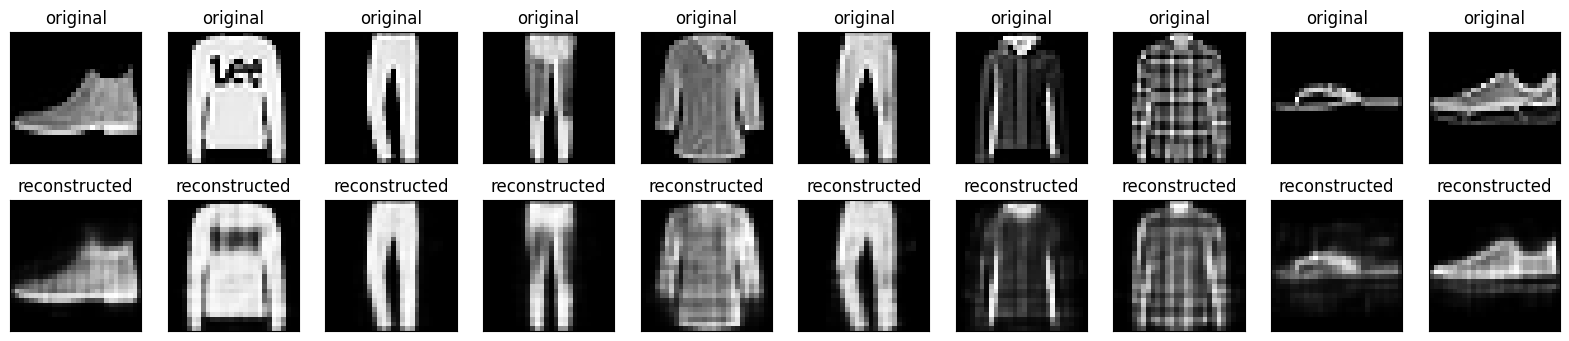

In [43]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
  ax = plt.subplot(2, n, i + 1)
  plt.imshow(x_test[i])
  plt.title("original")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)

  # display reconstruction
  ax = plt.subplot(2, n, i + 1 + n)
  plt.imshow(decoded_imgs[i])
  plt.title("reconstructed")
  plt.gray()
  ax.get_xaxis().set_visible(False)
  ax.get_yaxis().set_visible(False)
plt.show()

## **Example of Greedy Layer-wise Pretrain**

### Save and Load the Pretrain Autoencoder

In [36]:
path = 'autoencoder'

In [37]:
# Save the model
autoencoder.save(path, save_format='tf')

In [38]:
# Load the model
# Recreate the exact same model, including its weights and the optimizer
load_autoencoder = tf.keras.models.load_model(path)

### Apply the Pretrain Weights to our New Model

In [39]:
input = tf.keras.layers.Input(shape=(None, 784))
hidden = tf.keras.layers.Dense(64, activation='relu', weights=load_autoencoder.layers[0].get_weights(), trainable=False)(input)
output = tf.keras.layers.Dense(10, activation='softmax')(hidden)

In [40]:
model = Model(input, output)

In [41]:
model.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, None, 784)]       0         
                                                                 
 dense_11 (Dense)            (None, None, 64)          50240     
                                                                 
 dense_12 (Dense)            (None, None, 10)          650       
                                                                 
Total params: 50890 (198.79 KB)
Trainable params: 650 (2.54 KB)
Non-trainable params: 50240 (196.25 KB)
_________________________________________________________________
